In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [23]:
def plot(y, title, xlabel, ylabel, path=None):
  plt.figure(figsize=(8, 3))
  plt.plot(y, linestyle='-', color='black', linewidth=1.5)
  plt.title(title, fontsize=14)
  plt.xlabel(xlabel, fontsize=12)
  plt.ylabel(ylabel, fontsize=12)
  plt.grid(linestyle='--')
  plt.tight_layout()
  if path:
    plt.savefig(path, format='eps')


def show_matrix(name, matrix, decimal_places=2, scientific_notation=True):
  """
  Apresenta uma matriz com a quantidade de casas decimais desejadas.

  Parâmetros:
  ---
  - matrix: numpy.ndarray, a matriz a ser apresentada.
  - casas_decimais: int, o número de casas decimais desejadas (padrão é 2).
  """
  pattern = "{:." + str(decimal_places) + \
      ("e}" if scientific_notation else "f}")

  def format_elem(elem):
    return pattern.format(elem)

  width = [max(map(len, map(format_elem, coluna))) for coluna in matrix.T]

  print(name, "=")

  nspaces = sum(width) + 2 * matrix.shape[1]

  print("    ┌" + " " * nspaces + "┐")
  for line in matrix:
    formatted_line = "  ".join(format_elem(e).rjust(largura)
                               for e, largura in zip(line, width))
    print("    │ " + formatted_line + " │")
  print("    └" + " " * nspaces + "┘")
  print()


def sigmoid(x):
  return 1 / (1 + np.exp(-x))


def softmax(x):
  exps = np.exp(x - np.max(x, axis=1, keepdims=True))
  return exps / np.sum(exps, axis=1, keepdims=True)

In [24]:
class MultilayerPerceptron:
  def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1, precision=1e-6, task='r'):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.learning_rate = learning_rate
    self.precision = precision
    self.task = task

  def initialize_parameters(self, random_seed=None):
    if random_seed is not None:
      np.random.seed(random_seed)
    else:
      np.random.seed()

    self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.1
    self.b1 = np.zeros((1, self.hidden_size))
    self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.1
    self.b2 = np.zeros((1, self.output_size))

    self.VdW1 = np.zeros_like(self.W1)
    self.Vdb1 = np.zeros_like(self.b1)
    self.VdW2 = np.zeros_like(self.W2)
    self.Vdb2 = np.zeros_like(self.b2)

  def forward_propagation(self, X):
    self.Z1 = np.dot(X, self.W1) + self.b1
    self.A1 = sigmoid(self.Z1)
    self.Z2 = np.dot(self.A1, self.W2) + self.b2

    if self.task == 'c':
      self.y_hat = softmax(self.Z2)
    else:
      self.y_hat = self.Z2
    return self.y_hat

  def compute_loss(self, y_hat, y):
    if self.task == 'c':
      loss = -np.mean(np.sum(y * np.log(y_hat + 1e-8), axis=1))
    else:
      loss = np.mean(np.square(y_hat - y))
    return loss

  def compute_mse(self, y_hat, y):
    mse = np.mean((y_hat - y) ** 2)
    return mse

  def compute_relative_error(self, y_hat, y):
    relative_error = np.abs((y_hat - y) / y) * 100
    return relative_error

  def backward_propagation(self, X, y, y_hat):
    m = y.shape[0]

    dZ2 = y_hat - y
    dW2 = np.dot(self.A1.T, dZ2) / m
    db2 = np.mean(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, self.W2.T)
    dZ1 = dA1 * self.A1 * (1 - self.A1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.mean(dZ1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2

  def update_parameters(self, dW1, db1, dW2, db2, momentum=None):
    if momentum is not None:
      self.VdW1 = momentum * self.VdW1 + self.learning_rate * dW1
      self.Vdb1 = momentum * self.Vdb1 + self.learning_rate * db1
      self.VdW2 = momentum * self.VdW2 + self.learning_rate * dW2
      self.Vdb2 = momentum * self.Vdb2 + self.learning_rate * db2

      self.W1 -= self.VdW1
      self.b1 -= self.Vdb1
      self.W2 -= self.VdW2
      self.b2 -= self.Vdb2
    else:
      self.W1 -= self.learning_rate * dW1
      self.b1 -= self.learning_rate * db1
      self.W2 -= self.learning_rate * dW2
      self.b2 -= self.learning_rate * db2

  def fit(self, X, y, momentum=None, random_seed=None):
    start_time = time.time()
    self.initialize_parameters(random_seed=random_seed)

    mse_history = []
    epoch = 0
    previous_loss = float('inf')

    while True:
      y_hat = self.forward_propagation(X)
      loss = self.compute_loss(y_hat, y)
      mse = self.compute_mse(y_hat, y)
      mse_history.append(mse)

      dW1, db1, dW2, db2 = self.backward_propagation(X, y, y_hat)
      self.update_parameters(dW1, db1, dW2, db2, momentum)

      if abs(loss - previous_loss) <= self.precision:
        break

      epoch += 1
      previous_loss = loss

    end_time = time.time()
    processing_time = end_time - start_time

    return mse_history, epoch, processing_time

  def evaluate(self, X_test, y_test):
    y_hat_test = self.forward_propagation(X_test)
    if self.task == 'c':
      y_hat_test = (y_hat_test >= 0.5).astype(int)
    error = np.abs(y_hat_test - y_test)
    return y_hat_test, error

  def predict(self, X):
    y_hat = self.forward_propagation(X)
    return y_hat

,x1,x2,x3,d
0,0.8799,0.7998,0.3972,0.8399
1,0.5700,0.5111,0.2418,0.6258
2,0.6796,0.4117,0.3370,0.6622
3,0.3567,0.2967,0.6037,0.5969
4,0.3866,0.8390,0.0232,0.5316
...,...,...,...,...
195,0.0339,0.4669,0.1526,0.3250
196,0.0080,0.8988,0.4201,0.5404
197,0.9955,0.8897,0.6175,0.9360
198,0.7408,0.5351,0.2732,0.6949


,x1,x2,x3,d
0,0.0611,0.2860,0.7464,0.4831
1,0.5102,0.7464,0.0860,0.5965
2,0.0004,0.6916,0.5006,0.5318
3,0.9430,0.4476,0.2648,0.6843
4,0.1399,0.1610,0.2477,0.2872
5,0.6423,0.3229,0.8567,0.7663
6,0.6492,0.0007,0.6422,0.5666
7,0.1818,0.5078,0.9046,0.6601
8,0.7382,0.2647,0.1916,0.5427
9,0.3879,0.1307,0.8656,0.5836


Média dos MSEs: 1.4276e-02
Número de épocas: 2555
Tempo de processamento: 0.121 s
Previsões para dados de teste:
y_hat =
    ┌          ┐
    │ 4.98e-01 │
    │ 5.96e-01 │
    │ 5.37e-01 │
    │ 6.92e-01 │
    │ 3.24e-01 │
    │ 7.31e-01 │
    │ 5.65e-01 │
    │ 6.58e-01 │
    │ 5.44e-01 │
    │ 5.91e-01 │
    │ 6.71e-01 │
    │ 6.62e-01 │
    │ 3.34e-01 │
    │ 7.74e-01 │
    │ 4.81e-01 │
    │ 8.11e-01 │
    │ 7.64e-01 │
    │ 5.92e-01 │
    │ 7.91e-01 │
    │ 5.06e-01 │
    └          ┘

Erros relativos:
e (%) =
    ┌          ┐
    │ 2.99e-02 │
    │ 7.80e-04 │
    │ 9.68e-03 │
    │ 1.11e-02 │
    │ 1.29e-01 │
    │ 4.65e-02 │
    │ 1.98e-03 │
    │ 3.13e-03 │
    │ 2.82e-03 │
    │ 1.21e-02 │
    │ 3.50e-02 │
    │ 2.53e-02 │
    │ 1.31e-01 │
    │ 3.05e-04 │
    │ 3.09e-02 │
    │ 2.43e-03 │
    │ 7.50e-03 │
    │ 1.66e-02 │
    │ 3.90e-03 │
    │ 8.94e-03 │
    └          ┘



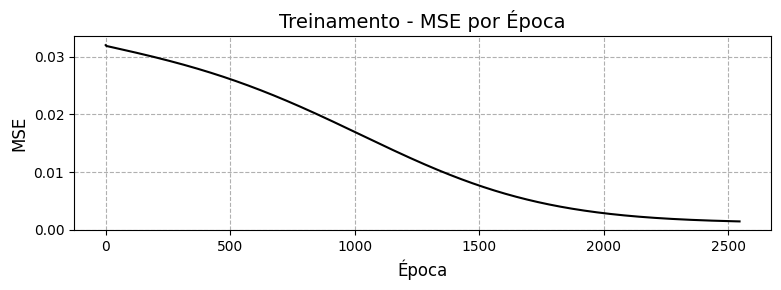

In [25]:

input_size = 3    # Tamanho de entrada
hidden_size = 10  # Tamanho da camada oculta
output_size = 1   # Tamanho de saída

# Obtenção dos dados para o treinamento e validação
df_train = pd.read_csv('5.8_RNA_train.txt', delim_whitespace=True)
df_test = pd.read_csv('5.8_RNA_test.txt', delim_whitespace=True)
display(df_train)
display(df_test)

X_train = df_train[['x1', 'x2', 'x3']].values
y_train = df_train[['d']].values

X_test = df_test[['x1', 'x2', 'x3']].values
y_test = df_test[['d']].values

# Criação do modelo
mlp = MultilayerPerceptron(input_size, hidden_size, output_size,
                           learning_rate=0.1, precision=1e-6)

# Treinamento do modelo
mse_history, epoch, processing_time = mlp.fit(X_train, y_train, random_seed=3)

# Avaliação do modelo
y_hat_test, error = mlp.evaluate(X_test, y_test)

print(f'Média dos MSEs: {np.mean(mse_history):.4e}')
print('Número de épocas:', epoch)
print(f'Tempo de processamento: {processing_time:.3f} s')
print('Previsões para dados de teste:')
show_matrix('y_hat', y_hat_test)
print('Erros relativos:')
show_matrix('e (%)', error / y_test)

plot(y=mse_history[10:],
     title='Treinamento - MSE por Época',
     xlabel='Época', ylabel='MSE',
     path='report/figures/p1-train-3.eps')

,x1,x2,x3,x4,d1,d2,d3
0,0.3841,0.2021,0.0000,0.2438,1.0,0.0,0.0
1,0.1765,0.1613,0.3401,0.0843,1.0,0.0,0.0
2,0.3170,0.5786,0.3387,0.4192,0.0,1.0,0.0
3,0.2467,0.0337,0.2699,0.3454,1.0,0.0,0.0
4,0.6102,0.8192,0.4679,0.4762,0.0,1.0,0.0
...,...,...,...,...,...,...,...
125,0.4155,0.6589,0.5310,0.5404,0.0,1.0,0.0
126,0.3934,0.6244,0.4817,0.4324,0.0,1.0,0.0
127,0.5843,0.8517,0.8576,0.7133,0.0,0.0,1.0
128,0.1995,0.3690,0.3537,0.3462,1.0,0.0,0.0


,x1,x2,x3,x4,d1,d2,d3
0,0.8622,0.7101,0.6236,0.7894,0,0,1
1,0.2741,0.1552,0.1333,0.1516,1,0,0
2,0.6772,0.8516,0.6543,0.7573,0,0,1
3,0.2178,0.5039,0.6415,0.5039,0,1,0
4,0.7260,0.7500,0.7007,0.4953,0,0,1
5,0.2473,0.2941,0.4248,0.3087,1,0,0
6,0.5682,0.5683,0.5054,0.4426,0,1,0
7,0.6566,0.6715,0.4952,0.3951,0,1,0
8,0.0705,0.4717,0.2921,0.2954,1,0,0
9,0.1187,0.2568,0.3140,0.3037,1,0,0


Média dos MSEs: 3.1468e-02
Número de épocas: 16562
Tempo de processamento: 1.395 s
Previsões para dados de teste:
y_hat =
    ┌         ┐
    │ 0  0  1 │
    │ 1  0  0 │
    │ 0  0  1 │
    │ 0  1  0 │
    │ 0  0  1 │
    │ 1  0  0 │
    │ 0  1  0 │
    │ 0  1  0 │
    │ 1  0  0 │
    │ 1  0  0 │
    │ 0  1  0 │
    │ 1  0  0 │
    │ 0  0  1 │
    │ 0  0  1 │
    │ 0  0  1 │
    │ 1  0  0 │
    │ 0  0  1 │
    │ 0  1  0 │
    └         ┘



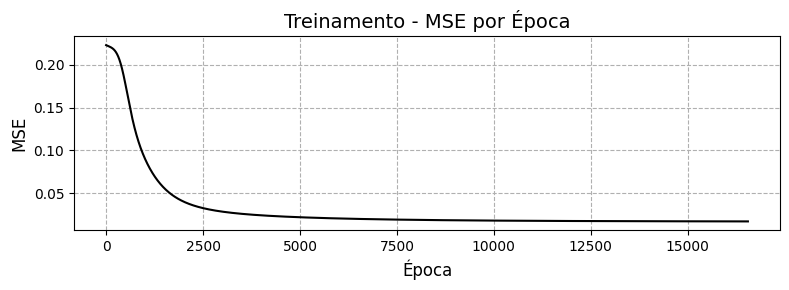

In [26]:
input_size = 4        # Tamanho de entrada
hidden_size = 15      # Tamanho da camada oculta
output_size = 3       # Tamanho de saída
learning_rate = 0.1   # Taxa de aprendizagem
precision = 1e-6      # Precisão
task = 'c'            # Tarefa: Classificação ('c')

# Obtenção dos dados para o treinamento e validação
df_train = pd.read_csv('5.9_RNA_train.txt', delim_whitespace=True)
df_test = pd.read_csv('5.9_RNA_test.txt', delim_whitespace=True)
display(df_train)
display(df_test)

X_train = df_train[['x1', 'x2', 'x3', 'x4']].values
y_train = df_train[['d1', 'd2', 'd3']].values

X_test = df_test[['x1', 'x2', 'x3', 'x4']].values
y_test = df_test[['d1', 'd2', 'd3']].values

# Criação do modelo
mlp = MultilayerPerceptron(input_size, hidden_size, output_size,
                           learning_rate=0.1, precision=1e-6, task='c')

# Treinamento do modelo
mse_history, epoch, processing_time = mlp.fit(X_train, y_train, random_seed=5)

# Avaliação do modelo
y_hat_test, relative_errors = mlp.evaluate(X_test, y_test)

print(f'Média dos MSEs: {np.mean(mse_history):.4e}')
print('Número de épocas:', epoch)
print(f'Tempo de processamento: {processing_time:.3f} s')
print('Previsões para dados de teste:')
show_matrix('y_hat', y_hat_test, 0, scientific_notation=False)

plot(y=mse_history[10:],
     title='Treinamento - MSE por Época',
     xlabel='Época', ylabel='MSE')

In [27]:
input_size = 4        # Tamanho de entrada
hidden_size = 15      # Tamanho da camada oculta
output_size = 3       # Tamanho de saída
learning_rate = 0.1   # Taxa de aprendizagem
precision = 1e-6      # Precisão
task = 'c'            # Tarefa: Classificação ('c')
momentum = 0.9        # Momentum

# Obtenção dos dados para o treinamento e validação
df_train = pd.read_csv('5.9_RNA_train.txt', delim_whitespace=True)
df_test = pd.read_csv('5.9_RNA_test.txt', delim_whitespace=True)
display(df_train)
display(df_test)

X_train = df_train[['x1', 'x2', 'x3', 'x4']].values
y_train = df_train[['d1', 'd2', 'd3']].values

X_test = df_test[['x1', 'x2', 'x3', 'x4']].values
y_test = df_test[['d1', 'd2', 'd3']].values

# Criação do modelo
mlp = MultilayerPerceptron(input_size, hidden_size, output_size,
                           learning_rate, precision, task)

# Treinamento do modelo
mse_history, epoch, processing_time = mlp.fit(
    X_train, y_train, momentum=0.9, random_seed=5)

# Avaliação do modelo
y_hat_test, relative_errors = mlp.evaluate(X_test, y_test)

print(f'Média dos MSEs: {np.mean(mse_history):.4e}')
print('Número de épocas:', epoch)
print(f'Tempo de processamento: {processing_time:.3f} s')
print('Previsões para dados de teste:')
show_matrix('y_hat', y_hat_test, 0, scientific_notation=False)

,x1,x2,x3,x4,d1,d2,d3
0,0.3841,0.2021,0.0000,0.2438,1.0,0.0,0.0
1,0.1765,0.1613,0.3401,0.0843,1.0,0.0,0.0
2,0.3170,0.5786,0.3387,0.4192,0.0,1.0,0.0
3,0.2467,0.0337,0.2699,0.3454,1.0,0.0,0.0
4,0.6102,0.8192,0.4679,0.4762,0.0,1.0,0.0
...,...,...,...,...,...,...,...
125,0.4155,0.6589,0.5310,0.5404,0.0,1.0,0.0
126,0.3934,0.6244,0.4817,0.4324,0.0,1.0,0.0
127,0.5843,0.8517,0.8576,0.7133,0.0,0.0,1.0
128,0.1995,0.3690,0.3537,0.3462,1.0,0.0,0.0


,x1,x2,x3,x4,d1,d2,d3
0,0.8622,0.7101,0.6236,0.7894,0,0,1
1,0.2741,0.1552,0.1333,0.1516,1,0,0
2,0.6772,0.8516,0.6543,0.7573,0,0,1
3,0.2178,0.5039,0.6415,0.5039,0,1,0
4,0.7260,0.7500,0.7007,0.4953,0,0,1
5,0.2473,0.2941,0.4248,0.3087,1,0,0
6,0.5682,0.5683,0.5054,0.4426,0,1,0
7,0.6566,0.6715,0.4952,0.3951,0,1,0
8,0.0705,0.4717,0.2921,0.2954,1,0,0
9,0.1187,0.2568,0.3140,0.3037,1,0,0


Média dos MSEs: 2.2996e-02
Número de épocas: 4485
Tempo de processamento: 0.426 s
Previsões para dados de teste:
y_hat =
    ┌         ┐
    │ 0  0  1 │
    │ 1  0  0 │
    │ 0  0  1 │
    │ 0  1  0 │
    │ 0  0  1 │
    │ 1  0  0 │
    │ 0  1  0 │
    │ 0  1  0 │
    │ 1  0  0 │
    │ 1  0  0 │
    │ 0  1  0 │
    │ 1  0  0 │
    │ 0  0  1 │
    │ 0  0  1 │
    │ 0  0  1 │
    │ 1  0  0 │
    │ 0  0  1 │
    │ 0  1  0 │
    └         ┘



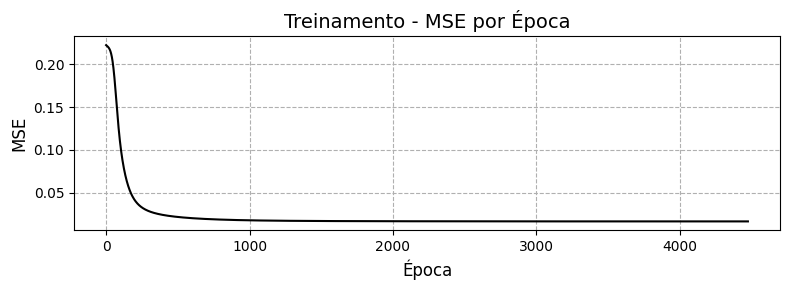

In [28]:
plot(y=mse_history[10:],
     title='Treinamento - MSE por Época',
     xlabel='Época', ylabel='MSE')